In [2]:
import cv2
import dlib
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
def load_images_from_folder(base_folder, img_size=(64, 64)):
    images = []
    labels = []
    # Loop through each folder in the base folder (real and fake videos)
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            # Check if the folder is real or fake
            label = 1 if 'real' in subfolder else 0  # Assuming folder names indicate the label
            # Load each image in the folder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Set directory path for the dataset
dataset_path = r'C:\Users\ahmed\Documents\Python Scripts\Deepfake Detection\FaceForensics'

# Load and preprocess images
images, labels = load_images_from_folder(dataset_path)

# Normalize image data
images = images / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Training samples: 16280
Test samples: 4071


In [4]:
def create_deepfake_detection_model(input_shape=(64, 64, 3)):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten the output for the fully connected layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real vs fake)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_deepfake_detection_model()

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model.save('deepfake_detection_model.h5')

Epoch 1/10
509/509 [==============================] - 151s 295ms/step - loss: 0.0014 - accuracy: 0.9990 - val_loss: 1.4262e-16 - val_accuracy: 1.0000
Epoch 2/10
509/509 [==============================] - 159s 313ms/step - loss: 6.0205e-21 - accuracy: 1.0000 - val_loss: 1.4262e-16 - val_accuracy: 1.0000
Epoch 3/10
509/509 [==============================] - 153s 302ms/step - loss: 1.2876e-21 - accuracy: 1.0000 - val_loss: 1.4262e-16 - val_accuracy: 1.0000
Epoch 6/10
509/509 [==============================] - 150s 294ms/step - loss: 5.6556e-21 - accuracy: 1.0000 - val_loss: 1.4262e-16 - val_accuracy: 1.0000
Epoch 7/10
509/509 [==============================] - 148s 291ms/step - loss: 7.7017e-20 - accuracy: 1.0000 - val_loss: 1.4262e-16 - val_accuracy: 1.0000
Epoch 8/10
509/509 [==============================] - 148s 290ms/step - loss: 2.8596e-20 - accuracy: 1.0000 - val_loss: 1.4262e-16 - val_accuracy: 1.0000
Epoch 9/10
509/509 [==============================] - 147s 288ms/step - loss: 1.

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

128/128 [==============================] - 3s 25ms/step - loss: 1.4262e-16 - accuracy: 1.0000
Test Accuracy: 100.00%
Test Loss: 0.0000


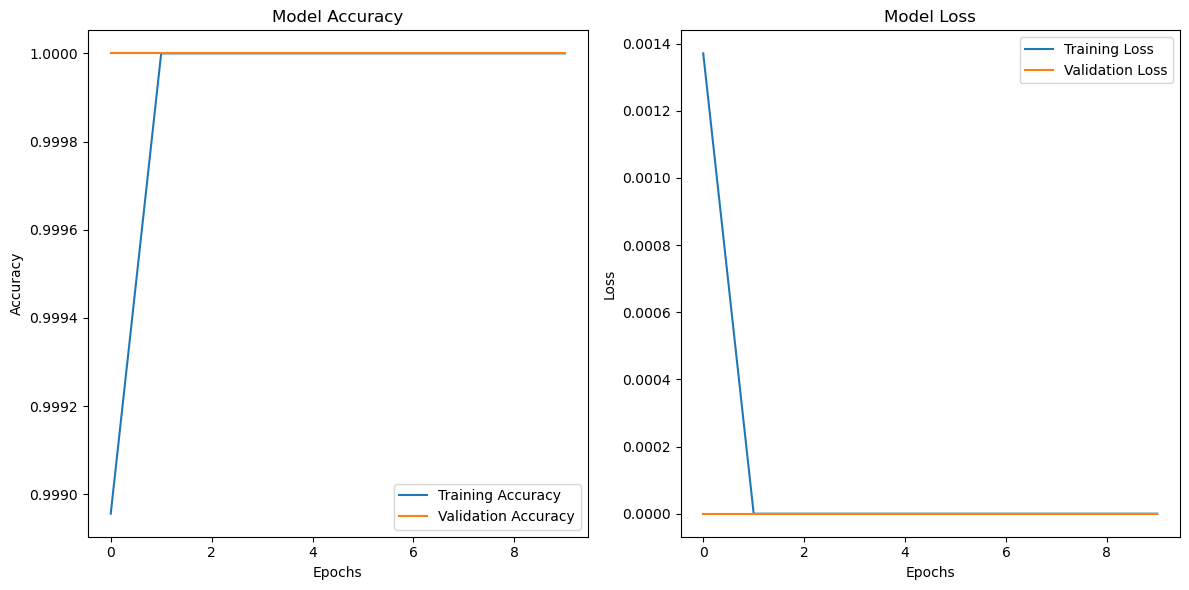

In [7]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
def predict_deepfake(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize
    prediction = model.predict(img)
    label = 'Fake' if prediction < 0.5 else 'Real'
    return label, prediction

# Test prediction on a new image
img_path = 'test.png'
label, prediction = predict_deepfake(model, img_path)
print(f"Prediction: {label}, Confidence: {prediction[0][0]:.4f}")

1/1 [==============================] - 0s 179ms/step
Prediction: Fake, Confidence: 0.0000
